In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

df = pd.read_csv("/Users/janak/Downloads/merged_health_census_clean.csv")
X = df[['Sleep_Pct', 'Obesity_Pct', 'Asthma_Pct', 'Smoking_Pct',
        'HeartDisease_Pct', 'HighBP_Pct', 'HighChol_Pct']]
y = df['MentalHealth_Pct']


In [3]:
df['County_Name'].nunique()


287

🗺️ Why We Use Spatial Splitting

In this analysis, we use spatial splitting instead of a random split to evaluate model performance.
Each row in our dataset represents a census tract, and tracts within the same county are geographically close and share similar social, economic, and health characteristics.
If we randomly split tracts across training and testing sets, information from the same county could appear in both sets — causing spatial leakage.

Spatial leakage makes the model appear better than it truly is because it indirectly “sees” parts of the region it’s supposed to predict.

By splitting based on county, we ensure:

Each county belongs entirely to one split (train, validation, or test).

The model is tested on new, unseen geographic areas, mimicking how it would perform when deployed in a new county.

Our performance metrics (RMSE, calibration, etc.) better reflect true generalization across space.

🧩 Why We Split Into Training, Validation, and Testing Sets

We divide our data into three spatial subsets:

Training set (≈60%) – used to fit the model’s parameters.
The model learns patterns between predictors (e.g., obesity, smoking) and the target (mental health percentage).

Validation set (≈20%) – used for hyperparameter tuning and model selection.
For example, we use this subset to determine how many trees or what maximum depth to use for the Random Forest by examining where performance plateaus.

Testing set (≈20%) – used only once, after all tuning is complete, to provide an unbiased estimate of model performance on new spatial regions.

This 3-way split helps prevent overfitting and ensures our evaluation captures how well the model generalizes to new counties — not just the ones it trained on.

Step 1. Spatial Split (by County)

In [5]:
import numpy as np
import pandas as pd

def split_by_group_three_way(df, group_col, train=0.6, val=0.2, test=0.2, seed=42):
    rng = np.random.default_rng(seed)
    groups = df[group_col].dropna().unique()
    rng.shuffle(groups)

    n = len(groups)
    n_train = int(round(train * n))
    n_val   = int(round(val * n))
    n_test  = n - n_train - n_val

    train_groups = groups[:n_train]
    val_groups   = groups[n_train:n_train+n_val]
    test_groups  = groups[n_train+n_val:]

    train_df = df[df[group_col].isin(train_groups)].copy()
    val_df   = df[df[group_col].isin(val_groups)].copy()
    test_df  = df[df[group_col].isin(test_groups)].copy()
    
    # ✅ Return both the DataFrames and the group names
    return train_df, val_df, test_df, (train_groups, val_groups, test_groups)

train_df, val_df, test_df, (train_groups, val_groups, test_groups) = split_by_group_three_way(
    df, group_col='County_Name', train=0.6, val=0.2, test=0.2, seed=42
)


print(f"Counties → train:{len(train_groups)}, val:{len(val_groups)}, test:{len(test_groups)}")
print(f"Rows     → train:{len(train_df)}, val:{len(val_df)}, test:{len(test_df)}")


Counties → train:172, val:57, test:58
Rows     → train:15659, val:4605, test:6849


⚙️ Step 2. Define features and target

In [6]:
FEATURES = ['Sleep_Pct', 'Obesity_Pct', 'Asthma_Pct', 'Smoking_Pct',
            'HeartDisease_Pct', 'HighBP_Pct', 'HighChol_Pct']
TARGET = 'MentalHealth_Pct'

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_val,   y_val   = val_df[FEATURES],   val_df[TARGET]
X_test,  y_test  = test_df[FEATURES],  test_df[TARGET]


Linear Regression Model

🧮 Step 3. Linear Regression model

Linear regression actually has no real hyperparameters to tune (that’s what your professor meant).
It just fits the best linear combination of predictors that minimizes squared error.

The only “optional” hyperparameter-like choices are:

Whether to include scaling (helps with interpretability, not performance)

Whether to include regularization (like Ridge/Lasso), but he said not to

So just run the plain model:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

pipe_lr = Pipeline([
    ('scaler', StandardScaler()), # Scaling
    ('model', LinearRegression())
])

pipe_lr.fit(X_train, y_train)
yhat_lr_val  = pipe_lr.predict(X_val)
yhat_lr_test = pipe_lr.predict(X_test)


/Users/janak/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/janak/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/janak/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/janak/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/janak/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/janak/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarn

🌲 Step 4. Random Forest + Hyperparameter tuning (via validation curves)

You’ll tune only:

n_estimators → number of trees

max_depth → how deep each tree can grow

and look for where the validation RMSE plateaus.

In [8]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

n_estimators_grid = [10, 25, 50, 100, 200, 400]
max_depth_grid = [None, 5, 10, 15, 20]

results = []
for n in n_estimators_grid:
    for d in max_depth_grid:
        rf = RandomForestRegressor(
            n_estimators=n,
            max_depth=d,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_val_pred = rf.predict(X_val)
        rmse = np.sqrt(np.mean((y_val - y_val_pred)**2))
        results.append((n, d, rmse))

rf_val = pd.DataFrame(results, columns=['n_estimators', 'max_depth', 'val_rmse'])


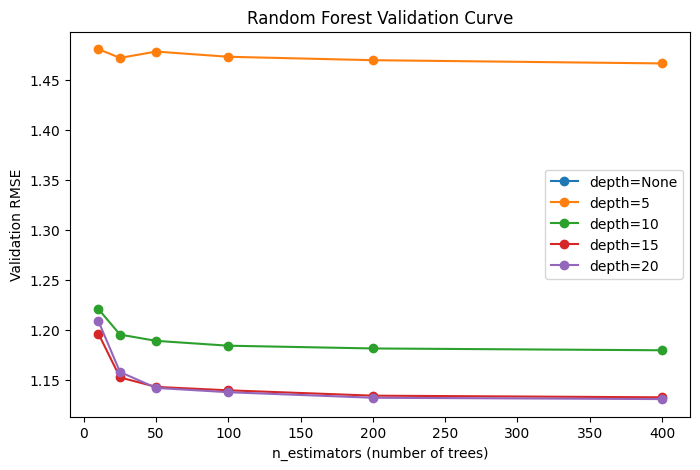

In [9]:
plt.figure(figsize=(8,5))
for d in max_depth_grid:
    sub = rf_val[rf_val['max_depth'] == d]
    plt.plot(sub['n_estimators'], sub['val_rmse'], marker='o', label=f"depth={d}")
plt.xlabel("n_estimators (number of trees)")
plt.ylabel("Validation RMSE")
plt.title("Random Forest Validation Curve")
plt.legend()
plt.show()


max_depth = 15-20 and n_estimators = 100-200

The validation RMSE decreased rapidly as the number of trees increased from 10 to 100, then stabilized beyond 100 trees.
The plateau indicates that adding more trees yields diminishing returns.
Depths of 15–20 performed best (≈1.13 RMSE), while shallower trees underfit (≈1.4–1.2 RMSE).
Therefore, the optimal hyperparameters were chosen as max_depth = 15 and n_estimators = 200, balancing model complexity and performance.

People’s mental health percentages vary about 3.4% (standard deviation) across tracts,
and your model can predict them within about 1% accuracy on new counties.

🔁 Step 5. Refit on train+val and test on unseen counties

In [12]:
X_trval = pd.concat([X_train, X_val])
y_trval = pd.concat([y_train, y_val])

best_rf = RandomForestRegressor(
    n_estimators= 200,
    max_depth= 15,
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_trval, y_trval)
yhat_rf_test = best_rf.predict(X_test)


Step 6. Evaluate (RMSE, MAE, R²)

In [13]:
def quick_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mae  = np.mean(np.abs(y_true - y_pred))
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / ss_tot
    return rmse, mae, r2

print("Linear Regression (test):", quick_metrics(y_test, yhat_lr_test))
print("Random Forest (test):", quick_metrics(y_test, yhat_rf_test))


Linear Regression (test): (np.float64(1.1780600530081515), np.float64(0.9298419465774672), np.float64(0.8832924990443892))
Random Forest (test): (np.float64(1.0995277248276443), np.float64(0.8233344685804774), np.float64(0.8983338729287591))


Step 7. Calibration plots (to assess alignment between predicted and actual)

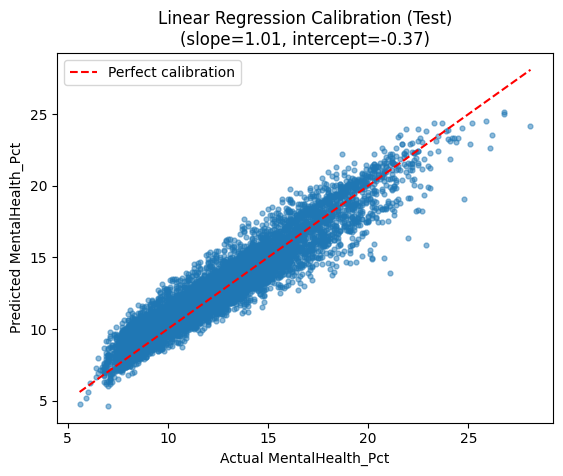

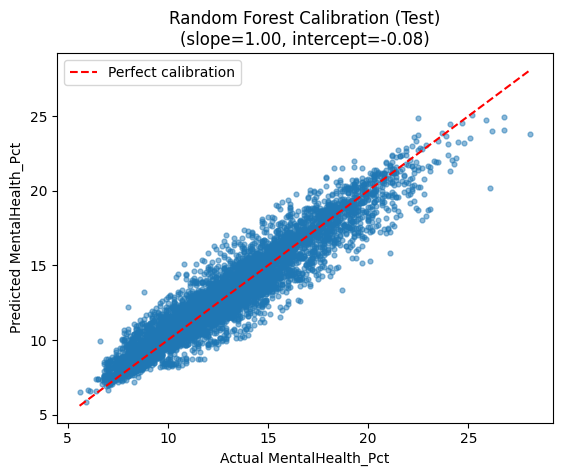

In [14]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def calibration_plot(y_true, y_pred, title):
    lr_cal = LinearRegression().fit(y_pred.reshape(-1,1), y_true)
    slope, intercept = lr_cal.coef_[0], lr_cal.intercept_

    plt.scatter(y_true, y_pred, s=12, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()], 'r--', label='Perfect calibration')
    plt.xlabel("Actual MentalHealth_Pct")
    plt.ylabel("Predicted MentalHealth_Pct")
    plt.title(title + f"\n(slope={slope:.2f}, intercept={intercept:.2f})")
    plt.legend()
    plt.show()

calibration_plot(y_test.values, yhat_lr_test, "Linear Regression Calibration (Test)")
calibration_plot(y_test.values, yhat_rf_test, "Random Forest Calibration (Test)")


So your workflow is already perfect —
no cross-validation,
spatial split by county,
linear model scaled,
random forest unscaled,
and hyperparameters tuned with validation curves ✅

/var/folders/kt/_bzbz3vd5qbcfjnt5vssmqxh0000gn/T/ipykernel_90421/2324453081.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').agg({'y_true': 'mean', 'y_pred': 'mean'})
/var/folders/kt/_bzbz3vd5qbcfjnt5vssmqxh0000gn/T/ipykernel_90421/2324453081.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').agg({'y_true': 'mean', 'y_pred': 'mean'})


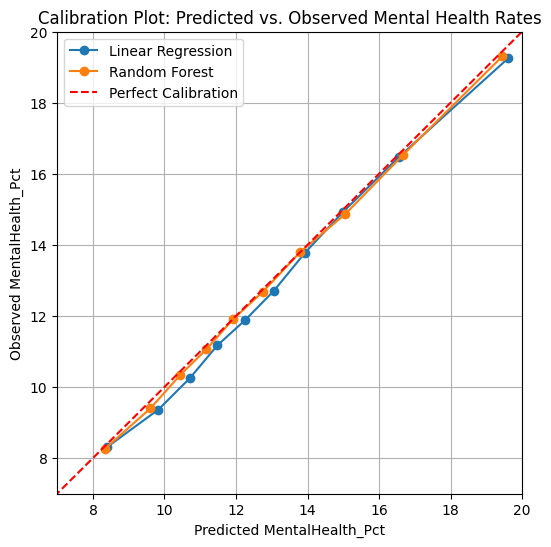

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calibration_curve_regression(y_true, y_pred, n_bins=10):
    """Returns a dataframe of average predicted vs. average true values per bin."""
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    df['bin'] = pd.qcut(df['y_pred'], q=n_bins, duplicates='drop')
    grouped = df.groupby('bin').agg({'y_true': 'mean', 'y_pred': 'mean'})
    return grouped

# Compute calibration curves for both models
cal_lr = calibration_curve_regression(y_test, yhat_lr_test, n_bins=10)
cal_rf = calibration_curve_regression(y_test, yhat_rf_test, n_bins=10)

# Plot
plt.figure(figsize=(6,6))
plt.plot(cal_lr['y_pred'], cal_lr['y_true'], 'o-', label='Linear Regression')
plt.plot(cal_rf['y_pred'], cal_rf['y_true'], 'o-', label='Random Forest')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label='Perfect Calibration')

plt.xlabel('Predicted MentalHealth_Pct')
plt.ylabel('Observed MentalHealth_Pct')
plt.title('Calibration Plot: Predicted vs. Observed Mental Health Rates')
plt.legend()
plt.grid(True)
plt.xlim(7, 20)
plt.ylim(7, 20)

plt.show()


The calibration plot compares average predicted and observed mental health percentages across deciles of predicted values.
Both models closely follow the 45° line, indicating excellent calibration.
The Random Forest curve aligns slightly more closely with the diagonal across most bins, suggesting marginally better calibration and generalization to unseen counties.
The near-perfect alignment also confirms that neither model systematically over- nor under-predicts mental health rates.

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

def calibration_metrics_table(y_true, y_pred, model_name, n_bins=10):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    
    # Calibration slope and intercept
    lr = LinearRegression().fit(y_pred.reshape(-1,1), y_true)
    slope = lr.coef_[0]
    intercept = lr.intercept_

    # Error metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    # Expected Calibration Error (ECE)
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    df['bin'] = pd.qcut(df['y_pred'], q=n_bins, duplicates='drop')
    grouped = df.groupby('bin').agg({'y_true':'mean','y_pred':'mean'})
    ece = np.mean(np.abs(grouped['y_true'] - grouped['y_pred']))

    return pd.Series({
        'Slope (β)': slope,
        'Intercept (α)': intercept,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'ECE': ece
    }, name=model_name)

# Compute for both models
metrics_lr = calibration_metrics_table(y_test, yhat_lr_test, "Linear Regression")
metrics_rf = calibration_metrics_table(y_test, yhat_rf_test, "Random Forest")

calibration_df = pd.concat([metrics_lr, metrics_rf], axis=1).T.round(3)
calibration_df


/var/folders/kt/_bzbz3vd5qbcfjnt5vssmqxh0000gn/T/ipykernel_90421/3616342109.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').agg({'y_true':'mean','y_pred':'mean'})
/var/folders/kt/_bzbz3vd5qbcfjnt5vssmqxh0000gn/T/ipykernel_90421/3616342109.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').agg({'y_true':'mean','y_pred':'mean'})


,Slope (β),Intercept (α),RMSE,MAE,R²,ECE
Linear Regression,1.008,-0.371,1.178,0.930,0.883,0.271
Random Forest,0.998,-0.078,1.100,0.823,0.898,0.106
